In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2024-06-13 13:46:18.337843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 13:46:18.337975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 13:46:18.465002: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
tf.__version__

'2.14.0'

In [5]:
source_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'  
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

In [6]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define classes
classes = ['Parasitized', 'Uninfected']

# Create train and test subdirectories for each class
for cls in classes:
    # Create subdirectories in train directory
    train_cls_dir = os.path.join(train_dir, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    
    # Create subdirectories in test directory
    test_cls_dir = os.path.join(test_dir, cls)
    os.makedirs(test_cls_dir, exist_ok=True)

    # Get list of files for the current class
    cls_files = os.listdir(os.path.join(source_dir, cls))
    # Split files into train and test sets
    train_files, test_files = train_test_split(cls_files, test_size=0.2, random_state=42)
    
    # Copy train files to train directory
    for file in train_files:
        src = os.path.join(source_dir, cls, file)
        dst = os.path.join(train_cls_dir, file)
        shutil.copy(src, dst)
    
    # Copy test files to test directory
    for file in test_files:
        src = os.path.join(source_dir, cls, file)
        dst = os.path.join(test_cls_dir, file)
        shutil.copy(src, dst)
shutil.rmtree(os.path.join(train_dir, 'cell_images'), ignore_errors=True)
shutil.rmtree(os.path.join(test_dir, 'cell_images'), ignore_errors=True)

Image size: 130 x 130


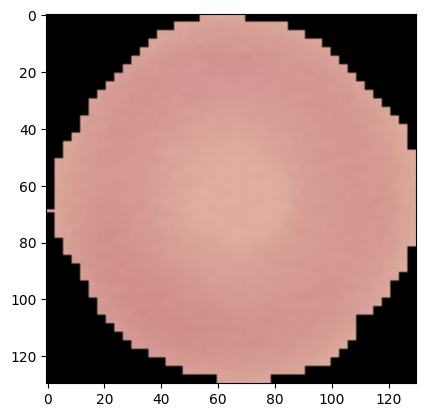

In [11]:
from PIL import Image
image_path='/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C100P61ThinF_IMG_20150918_145042_cell_59.png'
image = Image.open(image_path)

# Get the dimensions (width x height) of the image
width, height = image.size

print("Image size:", width, "x", height)
plt.imshow(image)


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'  
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),  
    batch_size=32,
    class_mode='binary'  
)

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [8]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in resnet_model.layers:
    layer.trainable = False
    
custom_layers = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model = tf.keras.models.Sequential([
    resnet_model,
    custom_layers
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
history1 = model.fit(train_generator, epochs=120, validation_data=test_generator)

Epoch 1/120


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/689 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.4878 - loss: 0.7433 

I0000 00:00:1712308908.519060     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712308908.571397     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


668/689 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5821 - loss: 0.6729

W0000 00:00:1712308941.076261     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5834 - loss: 0.6721

W0000 00:00:1712308946.186156     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - accuracy: 0.5834 - loss: 0.6721 - val_accuracy: 0.6856 - val_loss: 0.6042
Epoch 2/120


W0000 00:00:1712308955.887936     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.6564 - loss: 0.6236 - val_accuracy: 0.6896 - val_loss: 0.5909
Epoch 3/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.6791 - loss: 0.6021 - val_accuracy: 0.6838 - val_loss: 0.5868
Epoch 4/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.6922 - loss: 0.5877 - val_accuracy: 0.7221 - val_loss: 0.5517
Epoch 5/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.7100 - loss: 0.5677 - val_accuracy: 0.7362 - val_loss: 0.5306
Epoch 6/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.7081 - loss: 0.5650 - val_accuracy: 0.7371 - val_loss: 0.5180
Epoch 7/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.7332 - loss: 0.5371 - val_accuracy: 0.7471 - val_loss: 0.5134
Epoch 8/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.7258 - loss: 0.5353 - val_accuracy: 0.7507 - val_loss: 0.4992
Epoch 9/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.7407 - loss: 0.5225 - val_

Text(0, 0.5, 'Loss')

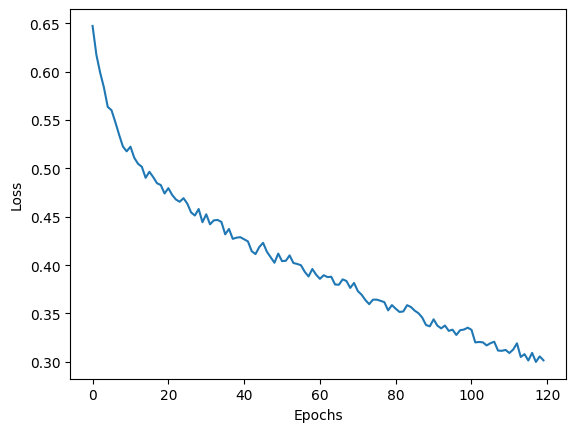

In [13]:
plt.plot(history1.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

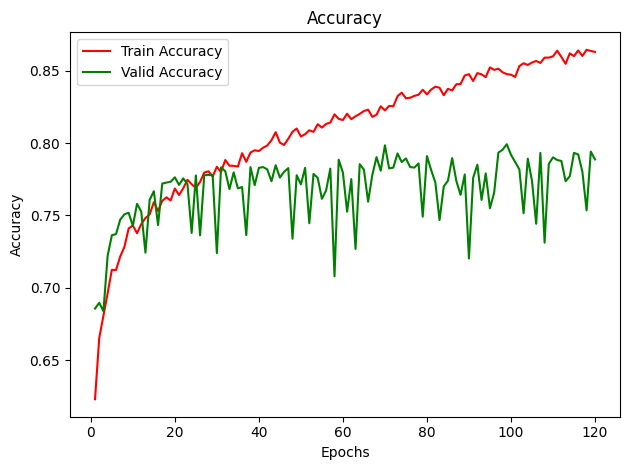

In [14]:
tr_acc = history1.history['accuracy']
tr_loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]


plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [55]:
def check_prediction(image_path,model):
    img = Image.open(image_path)
    class_labels = ['Parasitized', 'Uninfected']
    img = img.resize((128, 128))  # Resize image to match input size of the model
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    prediction = model.predict(img_array)
    #print(round(prediction[np.argmax(prediction)][0]))
    predicted_class = class_labels[round(prediction[np.argmax(prediction)][0])]
    return predicted_class

In [56]:
image_path1 ='/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'
image_path2 ='/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png'
image_path3 ='/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png'
print(check_prediction(image_path1,model))
print(check_prediction(image_path2,model))
print(check_prediction(image_path3,model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Parasitized
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Parasitized
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Uninfected


In [58]:
model_output_path = '/kaggle/working/my_model_1.keras'
if os.path.exists(model_output_path):
    os.remove(model_output_path)

tf.keras.backend.clear_session()
model.save(model_output_path)


In [59]:
new_model = tf.keras.models.load_model(model_output_path)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 222 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [60]:
print(check_prediction(image_path1,new_model))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Parasitized


In [61]:
tf.__version__

'2.15.0'

AttributeError: module 'tensorflow.keras' has no attribute '__version__'